# Boxing Bout Data
Dataset obtained from [Kaggle](https://www.kaggle.com/slonsky/boxing-bouts), which in turn was scraped from boxing bout records maintained by [BoxRec](http://boxrec.com/en/).

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
%matplotlib inline

# Surpress warnings
import warnings
warnings.filterwarnings("ignore")

# Pandas options set-up
pd.set_option("display.max_columns", 50)

# Colors for plotting
colors = ["#42a4f4", "#7d48cc", "#93cc49"]

## The Data
The dataset is one table with each row representing a boxing match. It contains variables for both match participants (labeled as boxer A and boxer B) on their respective age (years), height (cms), reach (cms), weight (lbs), stance (orthodox or southpaw), career games won, career games lost, career games drawn, and career games won by knockout (kos_A and kos_B).  Each record further contains a variable for the match result, decision type (knockout, technical knockout, unanimous decision, etc.), and variables for judge's scoring for each boxer. 

In [2]:
# Load data and display head
bouts = pd.read_csv("bouts_out_new.csv")
bouts.head()

,age_A,age_B,height_A,height_B,reach_A,reach_B,stance_A,stance_B,weight_A,weight_B,won_A,won_B,lost_A,lost_B,drawn_A,drawn_B,kos_A,kos_B,result,decision,judge1_A,judge1_B,judge2_A,judge2_B,judge3_A,judge3_B
0,35.0,27.0,179.0,175.0,178.0,179.0,orthodox,orthodox,160.0,160.0,37,49,0,1,0,1,33,34.0,draw,SD,110.0,118.0,115.0,113.0,114.0,114.0
1,26.0,31.0,175.0,185.0,179.0,185.0,orthodox,orthodox,164.0,164.0,48,50,1,2,1,1,34,32.0,win_A,UD,120.0,108.0,120.0,108.0,120.0,108.0
2,28.0,26.0,176.0,175.0,NaN,179.0,orthodox,orthodox,154.0,154.0,23,47,0,1,1,1,13,33.0,win_B,KO,NaN,NaN,NaN,NaN,NaN,NaN
3,25.0,29.0,175.0,174.0,179.0,180.0,orthodox,orthodox,155.0,155.0,46,31,1,3,1,0,32,19.0,win_A,KO,47.0,48.0,49.0,46.0,48.0,47.0
4,25.0,35.0,175.0,170.0,179.0,170.0,orthodox,orthodox,155.0,NaN,45,40,1,4,1,0,32,33.0,win_A,UD,118.0,110.0,119.0,109.0,117.0,111.0


In [3]:
bouts.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age_A,352888.0,24.416041,6.523590,-74.0,21.0,24.0,27.0,1818.0
age_B,257935.0,26.583345,11.823224,-74.0,23.0,26.0,30.0,2016.0
height_A,249246.0,172.786657,9.130127,2.0,166.0,173.0,178.0,255.0
height_B,134640.0,172.882657,9.430631,15.0,167.0,173.0,179.0,255.0
reach_A,112342.0,178.848605,12.002404,5.0,170.0,178.0,185.0,456.0
reach_B,37873.0,179.001030,14.867537,1.0,171.0,178.0,185.0,456.0
weight_A,135573.0,146.340636,30.240142,10.0,125.0,140.0,160.0,363.0
weight_B,130358.0,147.089484,30.624890,2.0,126.0,140.0,160.0,450.0
won_A,387427.0,23.108438,27.629901,0.0,5.0,14.0,31.0,332.0
won_B,387427.0,15.159080,19.938137,0.0,2.0,8.0,21.0,251.0


One of the first things we notice are the presence of some strange min/max values for age, height, reach, and weight. These will be dealt with later in the exploratory analysis section.

### Transforming the Data
To investigate the analytical questions asked in this report, we will transform the dataset from one where the rows represent boxing bouts, to one where the rows represent individual boxers. More specifically, after the transformation, each row will be a snapshot of a boxer's age, height, reach, weight, stance, and career record (win/loss/draw/wins-by-knockout) at the time of a specific bout, and also include the result of said bout, along with the decision type and judge's scoring.

In [4]:
# Transform the dataset from rows of bouts to rows of boxers
# Split the dataframe into two subset dataframes (boxer A and boxer B)

# Dataframe for boxer A
bouts_A = bouts[["age_A", "height_A", "reach_A", "stance_A", "weight_A",
                 "won_A", "lost_A", "drawn_A", "kos_A", "result", "decision",
                "judge1_A", "judge2_A", "judge3_A"]]

# Dataframe for boxer B
bouts_B = bouts[["age_B", "height_B", "reach_B", "stance_B", "weight_B",
                 "won_B", "lost_B", "drawn_B", "kos_B", "result", "decision",
                "judge1_B", "judge2_B", "judge3_B"]]

# Rename the columns for each of the subset dataframes to remove the A/B distinction,
# allowing them to be concatenated together.
combined_col_names = ['age', 'height', 'reach', 'stance', 'weight', 'won', 'lost', 'drawn',
                      'kos', 'result', 'decision','judge1', 'judge2', 'judge3']

bouts_A.columns = combined_col_names
bouts_B.columns = combined_col_names

# Replace result with a variable that gives the bout outcome from the prospective individual boxer (A or B)
# Create result list for boxer A
result_list_A = []
for result in bouts_A["result"]:
    if result == "win_A":
        result_list_A.append("won")
    elif result == "win_B":
        result_list_A.append("lost")
    elif result == "draw":
        result_list_A.append("draw")

#Replace result column with data from the new result_list
bouts_A["result"] = result_list_A

# Create result list for boxer B
result_list_B = []
for result in bouts_B["result"]:
    if result == "win_B":
        result_list_B.append("won")
    elif result == "win_A":
        result_list_B.append("lost")
    elif result == "draw":
        result_list_B.append("draw")

#Replace result column with data from the new result_list
bouts_B["result"] = result_list_B
    

# Concatente the the two subset dataframes into one combined dataframe
mega_bouts = pd.concat([bouts_A, bouts_B])

# Reset the index
mega_bouts = mega_bouts.reset_index(drop=True)

mega_bouts.head()

,age,height,reach,stance,weight,won,lost,drawn,kos,result,decision,judge1,judge2,judge3
0,35.0,179.0,178.0,orthodox,160.0,37,0,0,33.0,draw,SD,110.0,115.0,114.0
1,26.0,175.0,179.0,orthodox,164.0,48,1,1,34.0,won,UD,120.0,120.0,120.0
2,28.0,176.0,NaN,orthodox,154.0,23,0,1,13.0,lost,KO,NaN,NaN,NaN
3,25.0,175.0,179.0,orthodox,155.0,46,1,1,32.0,won,KO,47.0,49.0,48.0
4,25.0,175.0,179.0,orthodox,155.0,45,1,1,32.0,won,UD,118.0,119.0,117.0


In [5]:
mega_bouts.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,610823.0,25.331238,9.206592,-74.0,22.0,25.0,28.0,2016.0
height,383886.0,172.820327,9.236737,2.0,166.0,173.0,178.0,255.0
reach,150215.0,178.887035,12.785571,1.0,170.0,178.0,185.0,456.0
weight,265931.0,146.707717,30.431597,2.0,126.0,140.0,160.0,450.0
won,774854.0,19.133759,24.418594,0.0,3.0,11.0,26.0,332.0
lost,774854.0,7.047311,11.074890,0.0,1.0,3.0,9.0,511.0
drawn,774854.0,2.731428,5.313974,0.0,0.0,1.0,3.0,77.0
kos,774775.0,8.287020,10.921700,0.0,1.0,4.0,12.0,131.0
judge1,104308.0,61.147247,29.861542,0.0,38.0,56.0,80.0,540.0
judge2,140403.0,58.069286,30.680777,0.0,38.0,55.0,78.0,299.0


## Exploratory Analysis
First, we run a box plot for age, height, reach, and weight to investigate outliers.

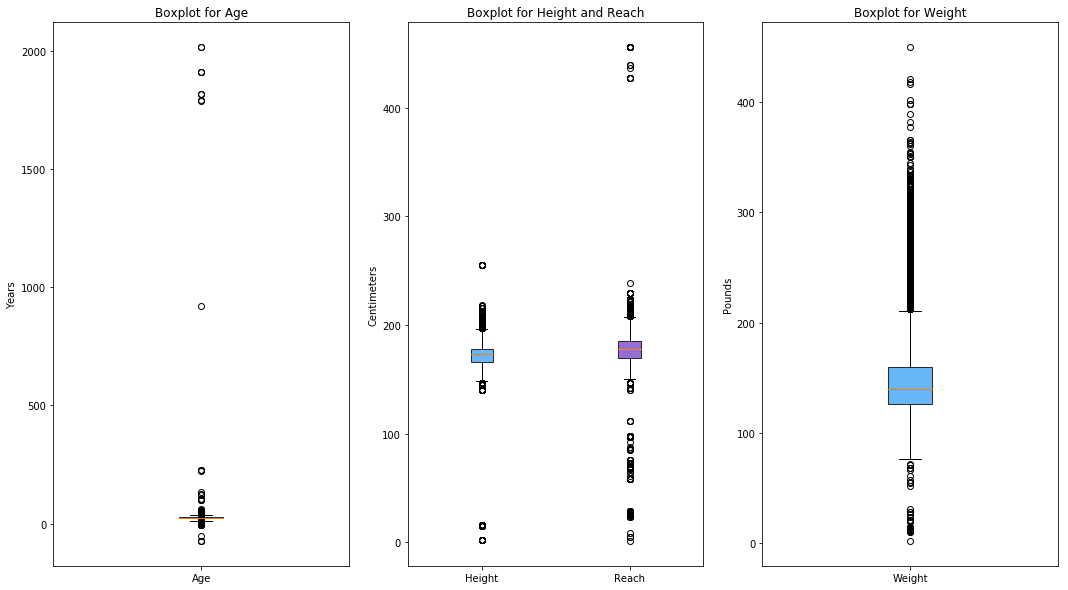

In [6]:
fig = plt.figure(figsize=(18, 10))
axes = fig.subplots(1, 3)

bplot1 = axes[0].boxplot(mega_bouts["age"].dropna(), patch_artist=True, labels=["Age"])
axes[0].set_title("Boxplot for Age")
axes[0].set_ylabel("Years")

bplot2 = axes[1].boxplot([mega_bouts["height"].dropna(), mega_bouts["reach"].dropna()], patch_artist=True,
                         labels=["Height", "Reach"])
axes[1].set_title("Boxplot for Height and Reach")
axes[1].set_ylabel("Centimeters")

bplot3 = axes[2].boxplot(mega_bouts["weight"].dropna(), patch_artist=True, labels=["Weight"])
axes[2].set_title("Boxplot for Weight")
axes[2].set_ylabel("Pounds")

for bplot in (bplot1, bplot2, bplot3):
    for patch, color in zip(bplot["boxes"], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.8)

plt.show()

Yikes! There are some problems here. After a little bit of research, I have set acceptable ranges for these variables as follows:
* __Age__: 15-60 years
* __Height__: 147-224 cms
* __Reach__: 130-250 cms
* __Weight__: 77-350 lbs

These are some what arbitrary and were obtained by googling things like “tallest professional boxer” and “youngest age to box professionally (15 years old in Mexico, it turns out). That being said, it does rein in the data and show what should be considered extreme or cleary wrong values (negative 74 is too young to be boxing--I don’t care if your parents signed a waiver).

In [7]:
# Remove observations with non-sensical data for age, height, weight, and reach.
mega_bouts = mega_bouts[(mega_bouts["age"] >= 15)]
mega_bouts = mega_bouts[(mega_bouts["age"] <= 60)]
mega_bouts = mega_bouts[(mega_bouts["height"] >= 147)]
mega_bouts = mega_bouts[(mega_bouts["height"] <= 224)]
mega_bouts = mega_bouts[(mega_bouts["weight"] >= 77)]
mega_bouts = mega_bouts[(mega_bouts["weight"] <= 350)]
mega_bouts = mega_bouts[(mega_bouts["reach"] >= 130)]
mega_bouts = mega_bouts[(mega_bouts["reach"] <= 250)]

In [8]:
mega_bouts.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,66614.0,25.757889,5.279800,15.0,22.0,25.0,29.0,54.0
height,66614.0,174.498214,9.096148,148.0,168.0,173.0,180.0,218.0
reach,66614.0,179.633095,11.428135,142.0,172.0,178.0,185.0,239.0
weight,66614.0,152.123608,33.873249,94.0,128.0,144.0,167.0,334.0
won,66614.0,29.975546,31.875268,0.0,10.0,21.0,38.0,262.0
lost,66614.0,5.497763,8.240858,0.0,0.0,2.0,7.0,102.0
drawn,66614.0,2.192287,4.956109,0.0,0.0,0.0,2.0,60.0
kos,66614.0,15.647176,15.210958,0.0,5.0,12.0,21.0,131.0
judge1,14901.0,75.850144,32.093473,0.0,50.0,79.0,100.0,240.0
judge2,18067.0,71.191122,35.356891,0.0,40.0,75.0,99.0,290.0


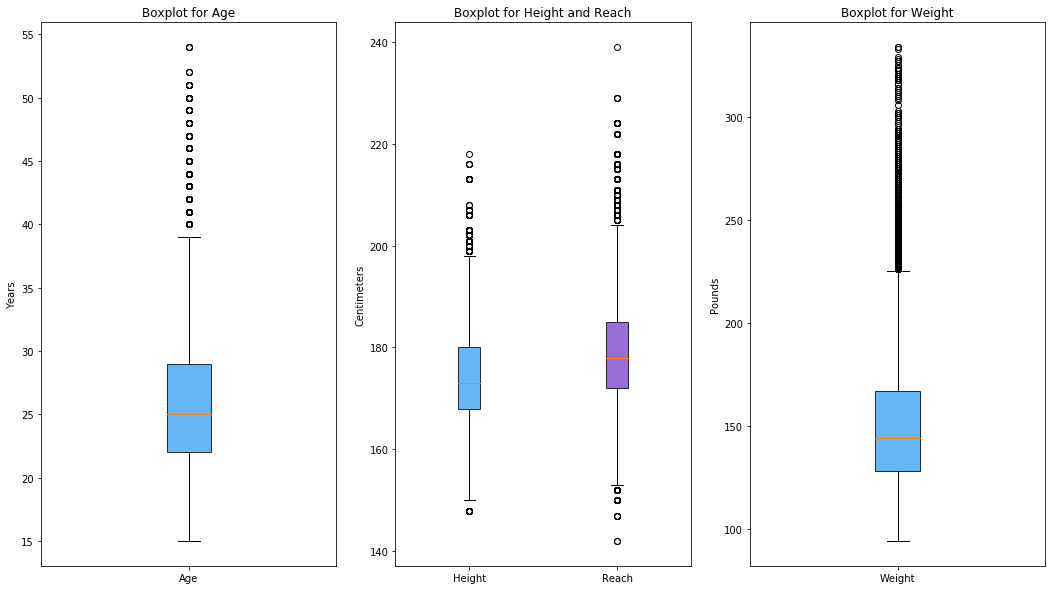

In [9]:
fig = plt.figure(figsize=(18, 10))
axes = fig.subplots(1, 3)

bplot1 = axes[0].boxplot(mega_bouts["age"].dropna(), patch_artist=True, labels=["Age"])
axes[0].set_title("Boxplot for Age")
axes[0].set_ylabel("Years")

bplot2 = axes[1].boxplot([mega_bouts["height"].dropna(), mega_bouts["reach"].dropna()], patch_artist=True,
                         labels=["Height", "Reach"])
axes[1].set_title("Boxplot for Height and Reach")
axes[1].set_ylabel("Centimeters")

bplot3 = axes[2].boxplot(mega_bouts["weight"].dropna(), patch_artist=True, labels=["Weight"])
axes[2].set_title("Boxplot for Weight")
axes[2].set_ylabel("Pounds")

for bplot in (bplot1, bplot2, bplot3):
    for patch, color in zip(bplot["boxes"], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.8)

plt.show()

Age, height, reach, and weight are now within the sensible limits. We proceed by running histograms for the quantitative variables.

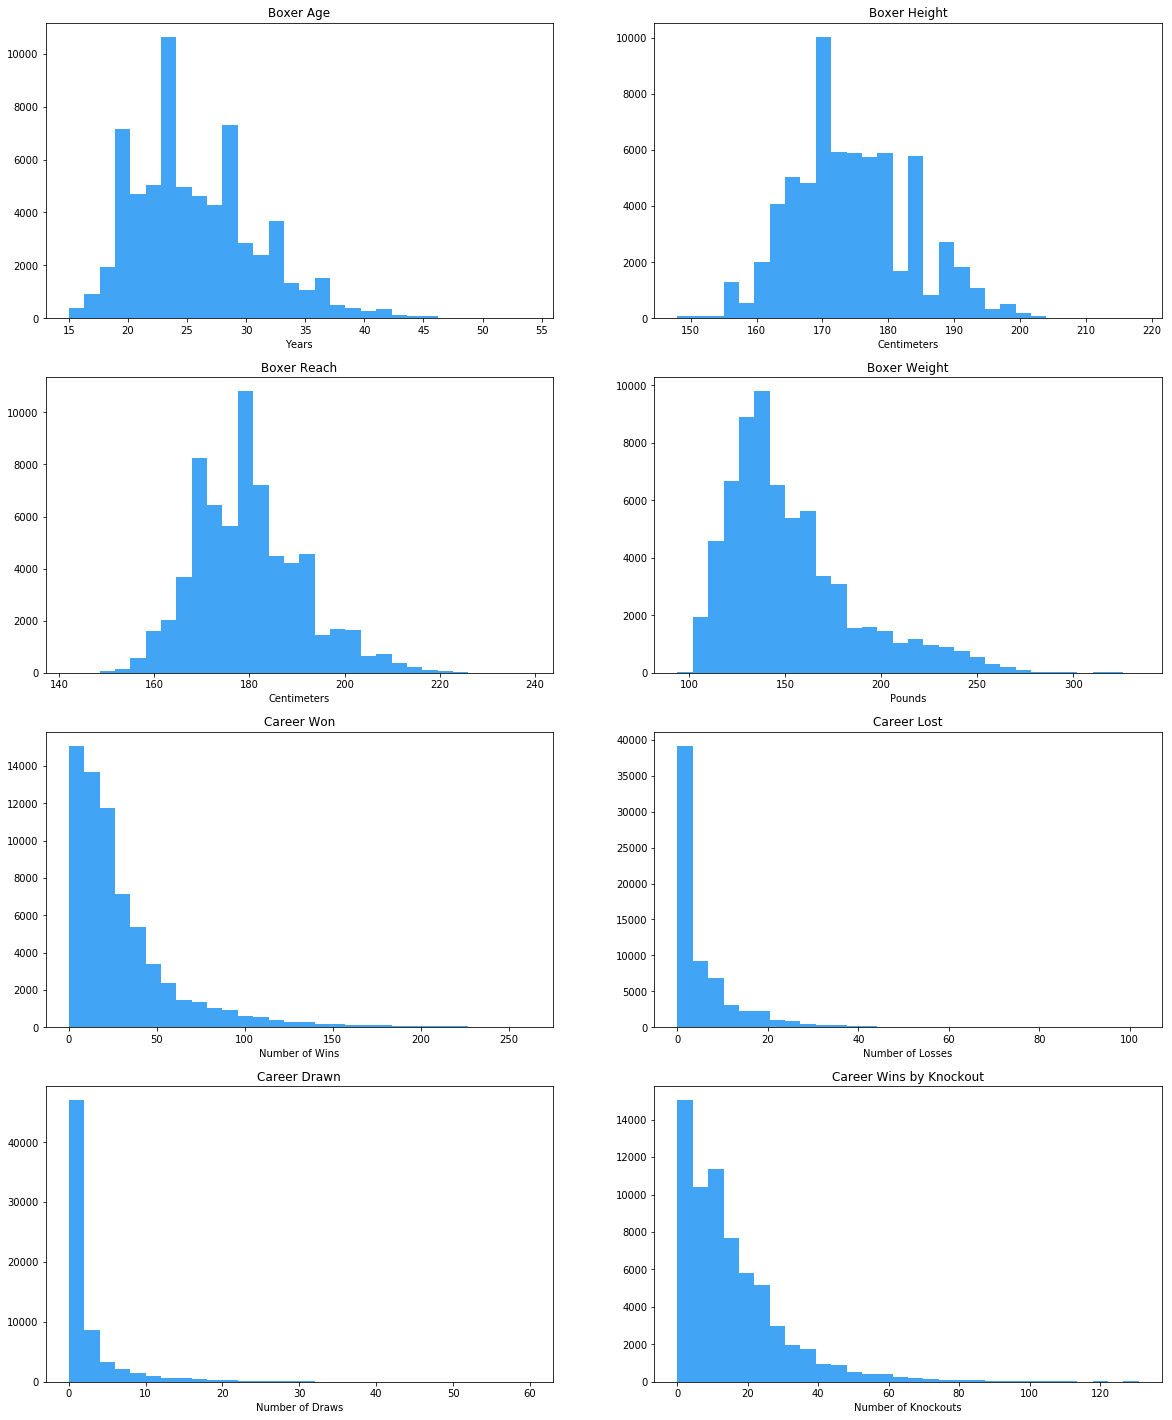

In [10]:
bins_num = 30

fig = plt.figure(figsize=(20, 25))
axes = fig.subplots(4, 2)
axes[0, 0].hist(mega_bouts["age"], bins=bins_num, color=colors[0])
axes[0, 0].set_title("Boxer Age")
axes[0, 0].set_xlabel("Years")

axes[0, 1].hist(mega_bouts["height"], bins=bins_num, color=colors[0])
axes[0, 1].set_title("Boxer Height")
axes[0, 1].set_xlabel("Centimeters")

axes[1, 0].hist(mega_bouts["reach"], bins=bins_num, color=colors[0])
axes[1, 0].set_title("Boxer Reach")
axes[1, 0].set_xlabel("Centimeters")

axes[1, 1].hist(mega_bouts["weight"], bins=bins_num, color=colors[0])
axes[1, 1].set_title("Boxer Weight")
axes[1, 1].set_xlabel("Pounds")

axes[2, 0].hist(mega_bouts["won"], bins=bins_num, color=colors[0])
axes[2, 0].set_title("Career Won")
axes[2, 0].set_xlabel("Number of Wins")

axes[2, 1].hist(mega_bouts["lost"], bins=bins_num, color=colors[0])
axes[2, 1].set_title("Career Lost")
axes[2, 1].set_xlabel("Number of Losses")

axes[3, 0].hist(mega_bouts["drawn"], bins=bins_num, color=colors[0])
axes[3, 0].set_title("Career Drawn")
axes[3, 0].set_xlabel("Number of Draws")

axes[3, 1].hist(mega_bouts["kos"], bins=bins_num, color=colors[0])
axes[3, 1].set_title("Career Wins by Knockout")
axes[3, 1].set_xlabel("Number of Knockouts")

plt.show()

The distributions of age, height, reach, and weight are roughly normally distributed, but all show a right skew. Career wins, losses, draws, and knockout distributions are all heavily skewed to the right.

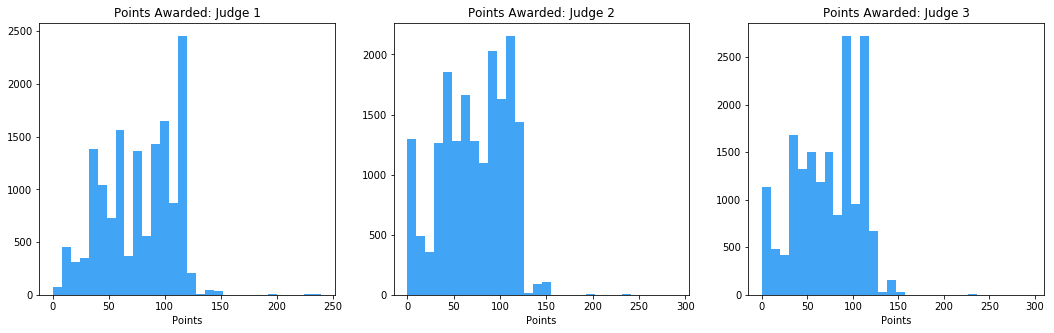

In [11]:
bins_num = 30

fig = plt.figure(figsize=(18, 5))
axes = fig.subplots(1, 3)
axes[0].hist(mega_bouts["judge1"].dropna(), bins=bins_num, color=colors[0])
axes[0].set_title("Points Awarded: Judge 1")
axes[0].set_xlabel("Points")

axes[1].hist(mega_bouts["judge2"].dropna(), bins=bins_num, color=colors[0])
axes[1].set_title("Points Awarded: Judge 2")
axes[1].set_xlabel("Points")

axes[2].hist(mega_bouts["judge3"].dropna(), bins=bins_num, color=colors[0])
axes[2].set_title("Points Awarded: Judge 3")
axes[2].set_xlabel("Points")

plt.show()

These variables are a bit more of a mess and don't appear to resemble much of any distribution.

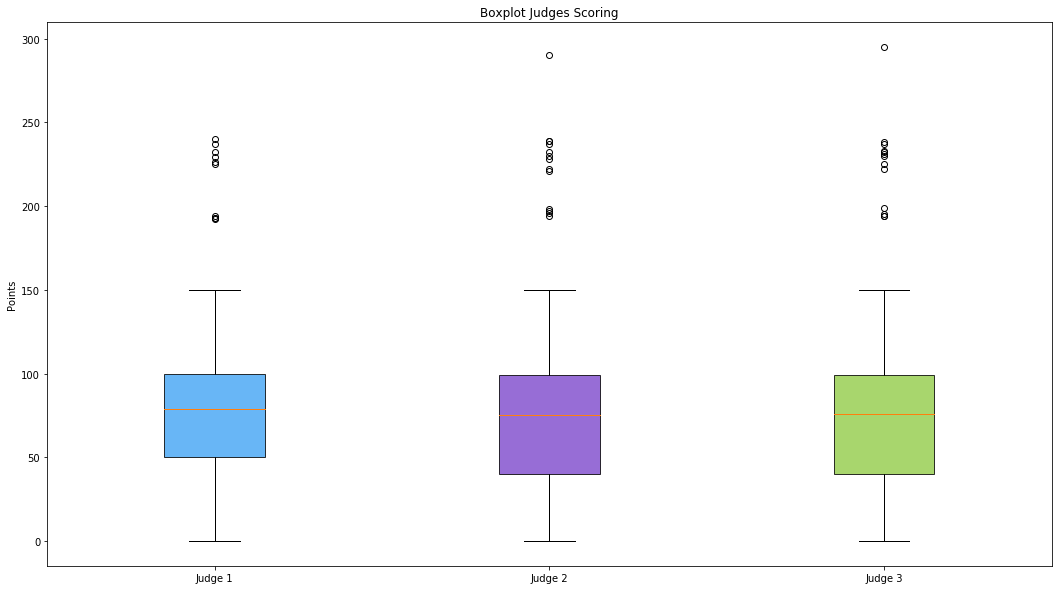

In [12]:
fig = plt.figure(figsize=(18, 10))
ax = fig.subplots()

bplot = ax.boxplot([mega_bouts["judge1"].dropna(), mega_bouts["judge2"].dropna(),
                      mega_bouts["judge3"].dropna()], patch_artist=True, labels=["Judge 1", "Judge 2", "Judge 3"])
ax.set_title("Boxplot Judges Scoring")
ax.set_ylabel("Points")

for bp in (bplot):
    for patch, color in zip(bplot["boxes"], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.8)

plt.show()

From the boxplot, we can see that scores typically range from about 40 to 100 points with a median at about 75 points. All three have noticeable outliers. 

Next we run a bar chart and to see how boxing bouts are typically decided. I pulled this data from the original dataset (before the transformation) to avoid double counting of result types. 

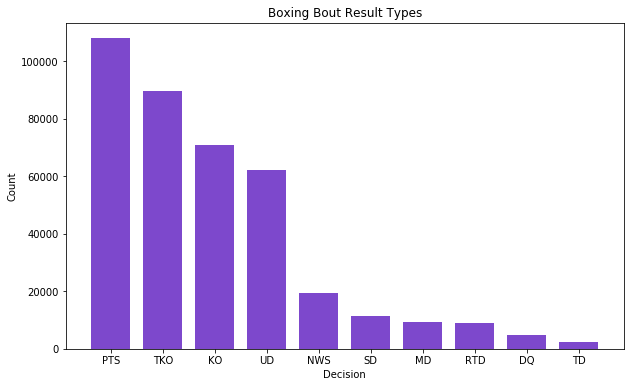

In [13]:
decision_values = bouts["decision"].value_counts().values
decision_labels = bouts["decision"].value_counts().index
bar_width = 0.75

fig = plt.figure(figsize=(10, 6))
ax = fig.subplots()
ax.bar(decision_labels, decision_values, bar_width, color=colors[1])
ax.set_title("Boxing Bout Result Types")
ax.set_xlabel("Decision")
ax.set_ylabel("Count")
plt.show()

We can see that the most common decision result is PTS (win on points). Per [BoxRec](http://boxrec.com/media/index.php/BoxRec_Fight_Record_Codes), this is a generic category for a points win where it is unknown how the judges scored the match.

Overall, most boxing matches are decided by PTS, TKO (technical knockout - the referee stops the fight due to, in the referee's judgment,  a boxer not being in a fit condition to continue), KO (knockout), and UD (unanimous decision - a points win where all three judges have scored in agreement).

The remaining results are  NWS (newspaper decision - [strange and interesting](http://boxrec.com/media/index.php/Newspaper_decision)), SD (split decision - two judges score in favor of one boxer, the other judge scores in favor of the other boxer), MD (majority decision - two judges score in favor of one boxer, the other judge scores in favor of a draw), RTD (retired between rounds - basically any fight stopped between rounds when the boxer or the boxer's team refuses to continue the fight), DQ (diqulified due to rule infringment and/or excessive fouls), and TD (techincal decision - losing the fight for headbutting the other boxer).

From this, we can see that referees and judges have a substantial impact and say in the outcomes of 
boxing bouts.

## Analytic Questions

### #1 Orthodox or southpaw boxers: who does better?
Is there any advantage to either boxing stance? First we will look at bar chart showing the proportion of wins, losses, and draws in the dataset.

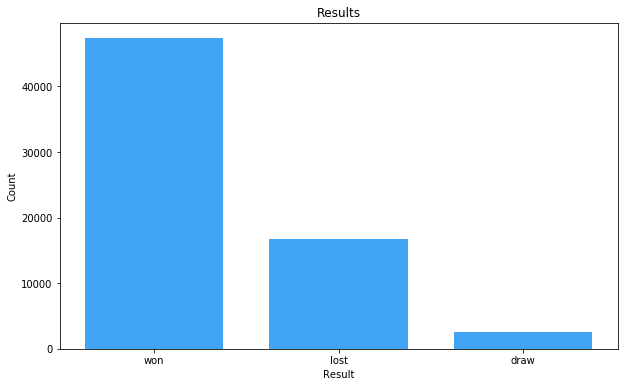

In [14]:
result_values = mega_bouts["result"].value_counts().values
result_labels = mega_bouts["result"].value_counts().index
bar_width = 0.75

fig = plt.figure(figsize=(10, 6))
ax = fig.subplots()
ax.bar(result_labels, result_values, bar_width, color=colors[0])
ax.set_title("Results")
ax.set_xlabel("Result")
ax.set_ylabel("Count")
plt.show()

We can see that most matches are decisive with few ending in a draw. Next we look at the proportion of orthodox to southpaw boxers.

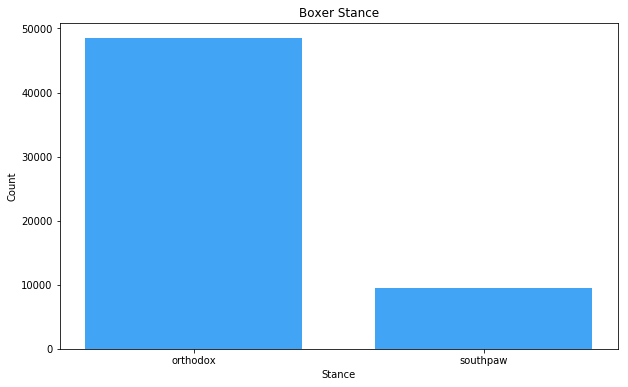

In [15]:
stance_values = mega_bouts["stance"].value_counts().values
stance_labels = mega_bouts["stance"].value_counts().index
bar_width = 0.75

fig = plt.figure(figsize=(10, 6))
ax = fig.subplots()
ax.bar(stance_labels, stance_values, bar_width, color=colors[0])
ax.set_title("Boxer Stance")
ax.set_xlabel("Stance")
ax.set_ylabel("Count")
plt.show()

There are a substantially more orthodox stance fighters. Finally, we calculate the winning frequency of both orthodox and southpaw boxers, and then graph the results. I define winning frequency as the ratio of wins to total bouts.

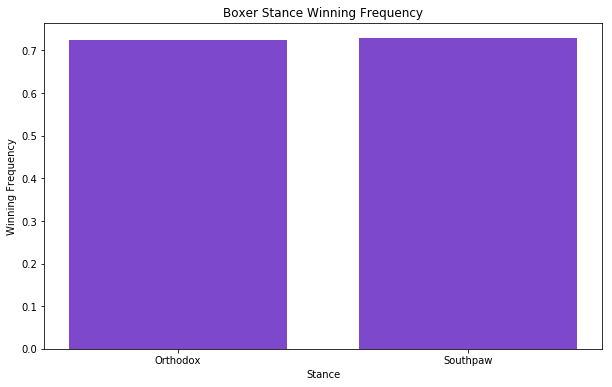

Orthodox winning frequency: 0.7241357973764541
Southpaw winning frequency: 0.728843736908253


In [16]:
# Calculate the winning frequency of orthodox stance boxers
# orthodox_wins / (orthodox_wins + orthodox_losses + orthodox_draws)
orthodox_win_frq = (mega_bouts[(mega_bouts["stance"] == "orthodox") & (mega_bouts["result"] == "won")]["result"].count()) / (mega_bouts[(mega_bouts["stance"] == "orthodox") & (mega_bouts["result"] == "won")]["result"].count() +
mega_bouts[(mega_bouts["stance"] == "orthodox") & (mega_bouts["result"] == "lost")]["result"].count() +
mega_bouts[(mega_bouts["stance"] == "orthodox") & (mega_bouts["result"] == "draw")]["result"].count())

# Calculate the winning frequency of southpaw stance boxers
# southpaw_wins / (southpaw_wins + southpaw_losses + southpaw_draws)
southpaw_win_frq = (mega_bouts[(mega_bouts["stance"] == "southpaw") & (mega_bouts["result"] == "won")]["result"].count()) / (mega_bouts[(mega_bouts["stance"] == "southpaw") & (mega_bouts["result"] == "won")]["result"].count() +
mega_bouts[(mega_bouts["stance"] == "southpaw") & (mega_bouts["result"] == "lost")]["result"].count() +
mega_bouts[(mega_bouts["stance"] == "southpaw") & (mega_bouts["result"] == "draw")]["result"].count())

stance_values = mega_bouts["stance"].value_counts().values
stance_labels = mega_bouts["stance"].value_counts().index
bar_width = 0.75

fig = plt.figure(figsize=(10, 6))
ax = fig.subplots()
ax.bar(["Orthodox", "Southpaw"], [orthodox_win_frq, southpaw_win_frq], bar_width, color=colors[1])
ax.set_title("Boxer Stance Winning Frequency")
ax.set_xlabel("Stance")
ax.set_ylabel("Winning Frequency")
plt.show()

print("Orthodox winning frequency: {}".format(orthodox_win_frq))
print("Southpaw winning frequency: {}".format(southpaw_win_frq))

It turns out that orthodox and southpaw boxers have almost the same winning frequency. We conclude that neither stance seems to have an advantage.

### #2 What factors play roles in winning a boxing bout?
Are the variables age, height, reach, and weight significant factors in determining the winner of a boxing bout? To investigate this, we divide the data into two groups by result (“won” or “lost”) and use the t-statistic to test if the group mean for each of the variables are significantly different.

The tests are run first without comment and discussed collectively at the end.

In [17]:
# Create an empty dataframe to store results
results_df = pd.DataFrame(index=["Age", "Height", "Reach", "Weight"],
                          columns=["t-stat", "p-value", "winner_group_mean", "loser_group_mean"])

# Define a function for the t-test and formatted output
def t_testing(sample1, sample2, labels, var_name, units="", append=True):
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(sample1, alpha=0.5, bins=20, color=colors[0], label=labels[0])
    plt.hist(sample2, alpha=0.5, bins=20, color=colors[2], label=labels[1])
    plt.title("Histogram of {}".format(var_name))
    plt.xlabel(units)
    plt.legend()
    plt.show()

    t_test_result = ttest_ind(sample2, sample1, equal_var=False)
    
    if append:
        results_df.loc[var_name]["t-stat"] = t_test_result[0]
        results_df.loc[var_name]["p-value"] = t_test_result[1]
        results_df.loc[var_name]["winner_group_mean"] = np.mean(sample1)
        results_df.loc[var_name]["loser_group_mean"] = np.mean(sample2)

    print("Mean of sample1 ({}): {}".format(labels[0], np.mean(sample1)))
    print("STD of sample1 ({}): {}".format(labels[0], np.std(sample1)))
    print()
    print("Mean of sample2 ({}): {}".format(labels[1], np.mean(sample2)))
    print("STD of sample2 ({}): {}".format(labels[1], np.std(sample2)))
    print()
    print("t-stat: {}\np-value: {}".format(t_test_result[0], t_test_result[1]))
    


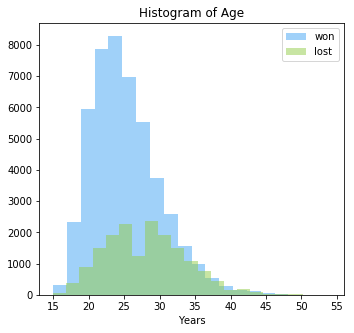

Mean of sample1 (won): 24.984918891517406
STD of sample1 (won): 4.9510258513344265

Mean of sample2 (lost): 28.006737017826268
STD of sample2 (lost): 5.560527683272274

t-stat: 62.186222635377604
p-value: 0.0


In [18]:
t_testing(mega_bouts[mega_bouts["result"] == "won"]["age"],
          mega_bouts[mega_bouts["result"] == "lost"]["age"], ("won", "lost"), "Age", "Years")

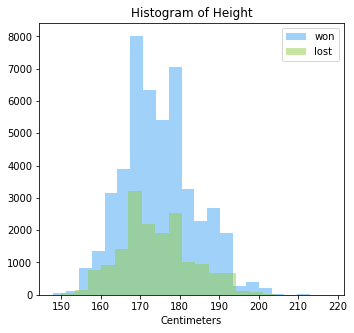

Mean of sample1 (won): 174.6968781683001
STD of sample1 (won): 9.118976388228548

Mean of sample2 (lost): 174.2215465331187
STD of sample2 (lost): 9.044333045540315

t-stat: -5.836079723187594
p-value: 5.399858579825885e-09


In [19]:
t_testing(mega_bouts[mega_bouts["result"] == "won"]["height"],
          mega_bouts[mega_bouts["result"] == "lost"]["height"], ("won", "lost"), "Height", "Centimeters")

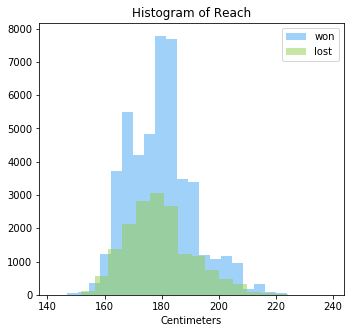

Mean of sample1 (won): 179.83465697870903
STD of sample1 (won): 11.443151227369311

Mean of sample2 (lost): 179.37697490013713
STD of sample2 (lost): 11.400759099161384

t-stat: -4.463215117340888
p-value: 8.103715409014988e-06


In [20]:
t_testing(mega_bouts[mega_bouts["result"] == "won"]["reach"],
          mega_bouts[mega_bouts["result"] == "lost"]["reach"], ("won", "lost"), "Reach", "Centimeters")

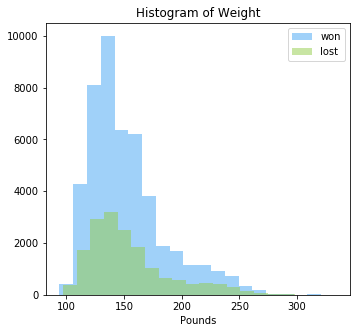

Mean of sample1 (won): 151.6146713416695
STD of sample1 (won): 33.3121550753208

Mean of sample2 (lost): 154.20062004411852
STD of sample2 (lost): 35.67286454691434

t-stat: 8.205712857855874
p-value: 2.3903874448927327e-16


In [21]:
t_testing(mega_bouts[mega_bouts["result"] == "won"]["weight"],
          mega_bouts[mega_bouts["result"] == "lost"]["weight"], ("won", "lost"), "Weight", "Pounds")

In [22]:
results_df.sort_values(by="t-stat", ascending=False)

,t-stat,p-value,winner_group_mean,loser_group_mean
Age,62.1862,0,24.9849,28.0067
Weight,8.20571,2.39039e-16,151.615,154.201
Reach,-4.46322,8.10372e-06,179.835,179.377
Height,-5.83608,5.39986e-09,174.697,174.222


We note the following results:
* The winner tends to be younger than the loser
* The winner tends to lighter in weight than the loser
* The winner tends to have a longer reach than the loser
* The winner tends to be taller than the loser

We conclude, as p-values show, all the above are statistically significant factors in the difference between the winner’s group and loser’s group.

Also, notice the similarity between reach and height. Below is scatter plot of the two variables:

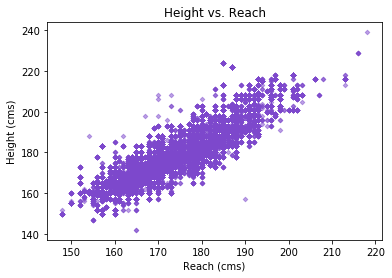

In [23]:
fig = plt.figure()
ax = fig.subplots()
ax.scatter(x=mega_bouts["height"], y=mega_bouts["reach"], s=10, marker="D", color=colors[1], alpha=0.5)
ax.set_title("Height vs. Reach")
ax.set_xlabel("Reach (cms)")
ax.set_ylabel("Height (cms)")
plt.show()

The plot shows a strong positive association between reach and height. Given this, the similarity between the two makes sense. 

### #3 How does a boxer's career history (win/loss/draw record and wins by knockout) factor into a bout outcome?
#### A. How does a boxer's career record factor in to winning a bout?
Does a boxer’s past success tell us anything about the outcome (win/lose) of a boxing bout? To investigate this, we first calculate the boxer’s career winning frequency and plot a histogram of the new variable.

In [24]:
# Calculate the career winning frequency for each boxer
# won / (won + lost + drawn)
mega_bouts["win_freq"] = mega_bouts["won"] / (mega_bouts["won"] + mega_bouts["lost"] + mega_bouts["drawn"])
mega_bouts["win_freq"].describe()

count    65068.000000
mean         0.827908
std          0.177159
min          0.000000
25%          0.746667
50%          0.865441
75%          0.970588
max          1.000000
Name: win_freq, dtype: float64

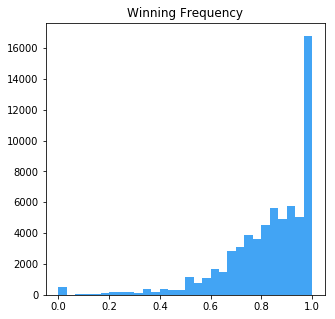

In [25]:
bins_num = 30

fig = plt.figure(figsize=(5, 5))
ax = fig.subplots()
ax.hist(mega_bouts["win_freq"].dropna(), bins=bins_num, color=colors[0])
ax.set_title("Winning Frequency")

plt.show()

The distribution shows we have a lot of undefeated boxers and a heavy left skew.

Next, we again use the t-statistic to test for significance of differences between the means for the  winner’s group career winning frequence and the loser’s group career winning frequency.

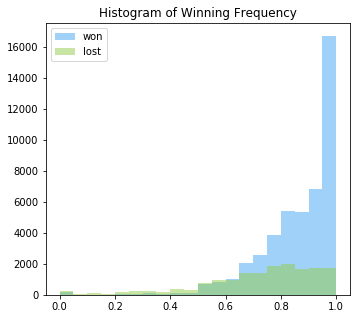

Mean of sample1 (won): 0.8674305658025312
STD of sample1 (won): 0.14554322090599214

Mean of sample2 (lost): 0.7270981742061203
STD of sample2 (lost): 0.21011762931535707

t-stat: -79.2385288664511
p-value: 0.0


In [26]:
t_testing(mega_bouts[mega_bouts["result"] == "won"]["win_freq"].dropna(),
          mega_bouts[mega_bouts["result"] == "lost"]["win_freq"].dropna(), ("won", "lost"), "Winning Frequency",
         append=False)

We conclude that the difference between the means is significant, and that past career success is an important factor differentiating the winner of a bout between the loser of a bout. Specifically, the winner of the bout tends to have a higher career winning frequency.

#### B. Does a boxer's win by knockout history in anyway factor into winning a bout?

Does a boxer’s record of wins by knockout tell us anything about the match outcome? We calculate the boxer’s win by knockout frequency, which I define as the ratio of wins-by-knockout to wins, and run the usual descriptive statistics and histogram plot on the new variable.

In [27]:
# Calculate the career wins by knockout (kos) frequency for each boxer
# kos / won

mega_bouts["kos_freq"] = mega_bouts["kos"] / mega_bouts["won"]
mega_bouts["kos_freq"].describe()

count    64591.000000
mean         0.585754
std          0.241289
min          0.000000
25%          0.424242
50%          0.603774
75%          0.755556
max          1.000000
Name: kos_freq, dtype: float64

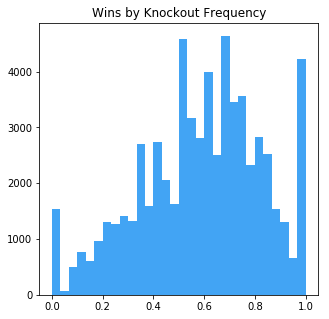

In [28]:
bins_num = 30

fig = plt.figure(figsize=(5, 5))
ax = fig.subplots()
ax.hist(mega_bouts["kos_freq"].dropna(), bins=bins_num, color=colors[0])
ax.set_title("Wins by Knockout Frequency")

plt.show()

The distribution is roughly normal with a left skew. As with winning frequency, there are a lot of boxer’s with perfect scores (1.0) in this variable.

Again, we calculate the t-statistic to test for significance of differences between the means for the winner’s group  and the loser’s group knockout frequency.

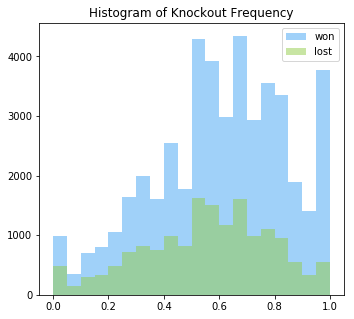

Mean of sample1 (won): 0.6028517277059775
STD of sample1 (won): 0.24145713863740842

Mean of sample2 (lost): 0.551908394015014
STD of sample2 (lost): 0.23187771313629119

t-stat: -23.79901550793483
p-value: 5.0525421527732344e-124


In [29]:
t_testing(mega_bouts[mega_bouts["result"] == "won"]["kos_freq"].dropna(),
          mega_bouts[mega_bouts["result"] == "lost"]["kos_freq"].dropna(), ("won", "lost"), "Knockout Frequency",
         append=False)

We conclude that the difference between the means is significant, and that higher knockout frequency is an important factor differentiating the winner of a bout between the loser of a bout.

#### C. Is a boxer's win by knockout history a factor to winning a bout by knockout?

Does a boxer’s record of wins by knockout tell us anything about winning the current bout __by knockout__ (as opposed to winning by TKO or PTS)? This could be taken to show if there is skill invloved to winning by knockout rather than just luck.

To examine this, we spit the data into two groups: 1) boxers who won the bout __and__ won by knockout, and 2) boxers who won the bout, but won by means other than knockout. We then use the t-statistic to test if there is a significant difference between the means of the two groups regarding knockout frequency (the variable we calculated to answer the question above).

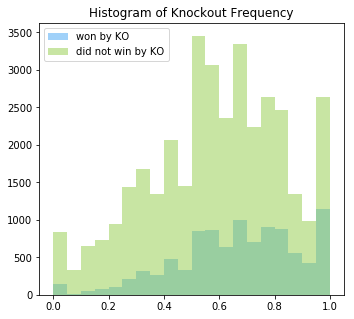

Mean of sample1 (won by KO): 0.6643420091526926
STD of sample1 (won by KO): 0.222981766891394

Mean of sample2 (did not win by KO): 0.5858443590515965
STD of sample2 (did not win by KO): 0.24359763986087818

t-stat: -30.45584313970466
p-value: 1.9345314369194235e-198


In [30]:
won_and_ko = mega_bouts[(mega_bouts["result"] == "won") & (mega_bouts["decision"] == "KO")]["kos_freq"]
won_and_not_ko = mega_bouts[(mega_bouts["result"] == "won") & (mega_bouts["decision"] != "KO")]["kos_freq"]
t_testing(won_and_ko.dropna(), won_and_not_ko.dropna(), ("won by KO", "did not win by KO"), "Knockout Frequency",
         append=False)

We conclude that the difference between the means is significant. Thus, a higher knockout frequency is an important factor differentiating winning a bout by knockout and winning by means other than knockout. It would appear that winning by knockout involves some skill.

## Further Research
Regarding further research, it would be interesting to see if we could use supervised learning to develop a model that can predict the outcome of a bout using age, height, weight, reach, and career history.